<a href="https://colab.research.google.com/github/mabail6/cat-and-dog-image-classifier/blob/master/cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The challenge: For this challenge, I will classify images of dogs and cats using Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if I get it to 70% accuracy!)


---
The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

In [1]:
# Import libraries
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get project files
# Use this in google colab
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Creating image generators for each of the three image data sets (train, validation, test). Using `ImageDataGenerator` to read / decode the images and convert them into floating point tensors and the `rescale` argument to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, using the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects.


The output should look like this:
```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                           batch_size=batch_size,
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                              batch_size=batch_size,
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(PATH,
                                                         target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                         batch_size=batch_size,
                                                         classes=["test"],
                                                         class_mode='sparse',
                                                         shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional.

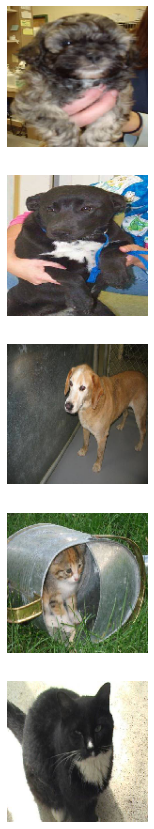

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreating the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.


In [ ]:
train_image_generator = ImageDataGenerator(rotation_range=40,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode='nearest',
                                           rescale=1./255
)


`train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


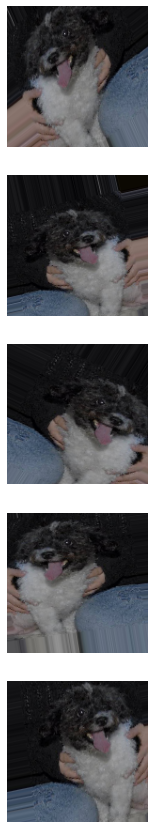

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

Create a model for the neural network that outputs class probabilities using the Keras Sequential model. Includes a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also passing in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Computing the steps per epoch from the batch size to better estimate the steps per epoch as well as validation steps.

In [ ]:
import math

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(total_train)
val_steps = compute_steps_per_epoch(total_val)

Using the `fit` method on the `model` to train the network.

In [ ]:
history = model.fit(train_data_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=val_steps)

Epoch 1/15
16/16 [==============================] - 65s 4s/step - loss: 0.6881 - accuracy: 0.5150 - val_loss: 0.6611 - val_accuracy: 0.5550
Epoch 2/15
16/16 [==============================] - 64s 4s/step - loss: 0.6762 - accuracy: 0.5680 - val_loss: 0.6614 - val_accuracy: 0.5420
Epoch 3/15
16/16 [==============================] - 65s 4s/step - loss: 0.6584 - accuracy: 0.5780 - val_loss: 0.6291 - val_accuracy: 0.6440
Epoch 4/15
16/16 [==============================] - 65s 4s/step - loss: 0.6430 - accuracy: 0.6250 - val_loss: 0.6629 - val_accuracy: 0.5960
Epoch 5/15
16/16 [==============================] - 67s 4s/step - loss: 0.6293 - accuracy: 0.6400 - val_loss: 0.5900 - val_accuracy: 0.6840
Epoch 6/15
16/16 [==============================] - 68s 4s/step - loss: 0.6387 - accuracy: 0.6320 - val_loss: 0.6106 - val_accuracy: 0.6700
Epoch 7/15
16/16 [==============================] - 66s 4s/step - loss: 0.6183 - accuracy: 0.6560 - val_loss: 0.5924 - val_accuracy: 0.6800
Epoch 8/15
16/16 [==

Saving the model for future use.

In [ ]:
model.save('dogs_vs_cats.h5')

Visualize the accuracy and loss of the model.

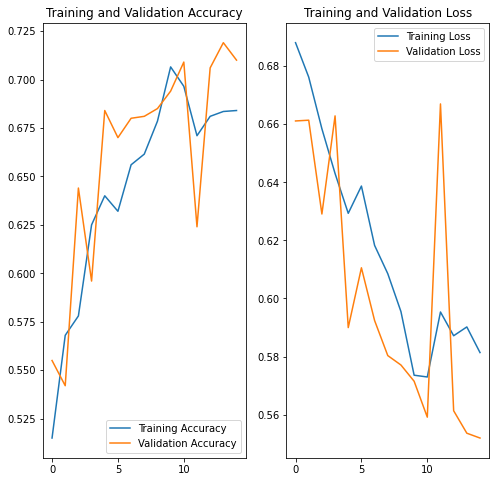

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Using the model to predict whether a brand new image is a cat or a dog.

Get the probability that each test image (from `test_data_gen`) is a dog or a cat.

Calling the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

See all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [ ]:
probabilities = model.predict(test_data_gen)

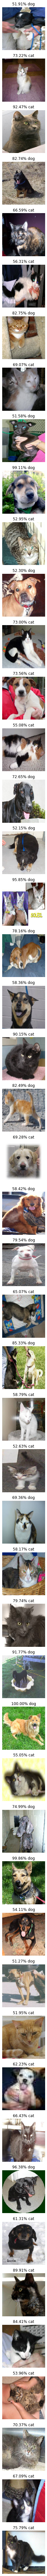

In [ ]:
plotImages(test_data_gen[0][0], probabilities=probabilities)

Run this final cell to see if I passed the challenge or if I need to keep trying.

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.82% of the images of cats and dogs.
You passed the challenge!
